In [90]:
"""
This is a trained LSTM to predict Brent price
Author: Valentin Todorov

"""

# Import the functions and classes we'll need
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import backend as K
from keras import optimizers

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


### Provide input values to parameters
# Read in the data
cwd = os.getcwd()
dataLocation = "/home/valentint/EAA_Analytics/Personal/VT/"
inputFile = "file_for_lstm_model_logdiff"

brentPriceDf = pd.read_csv(dataLocation + inputFile + ".csv")
brentPriceDf.head(10)

# Remove the forecasts from the data
# inputData.BrentPrice[[inputData.Date > 2017-01-01 00:00:00]] = 0

# Format "Date" field as date
brentPriceDf[['date']] = pd.to_datetime(brentPriceDf.date)

# Convert the data frame to a Numpy array
brentPriceArr = brentPriceDf.iloc[:, 0:].values

# Select random seed
randSeed = 7896

# Provide names of input features
inputDataFrame = brentPriceDf
inputData = brentPriceArr

# Create a Numpy array from the input data
dataframe = inputData[:, 1:, ]
# xVarColumns = [1, 2, 3]                                   # Select features: BY DEFAULT, it uses all features in columns 1:END for predictors
yVarColumns = [0]                                           # Select target: The target should always be in the first column
number_of_features = len(list(brentPriceDf)) - 2            # Calculate the number of features to be used in the network


In [91]:
########################################################
# Sanity checks of the data
########################################################

print(number_of_features, "\nThe analytical array shape is (includes the target):", dataframe.shape)
brentPriceDf.head(10)


23 
The analytical array shape is (includes the target): (207, 24)


,date,target,v137013095,v155478663,v179715733,pmiMfctg,inventoryChange,globalInventory,v1106237782,v1106492632,...,ipOECD,usDollar,globalDemand,gasolineDemand,oecdLiquidsDemand,vehicleSales,oecdStocks,opecSupply,auto_sales,v134253300_level_lag
0,2000-03-01,-0.005808,0.413467,3.5,0.598205,4.007333,-2292,-2639,0.009391,-0.017291,...,0.010152,0.017242,0.044344,0.062864,0.040506,0.070056,-0.006329,0.026415,0.070056,27.63
1,2000-04-01,-0.197803,0.588235,1.0,0.693756,4.025352,-761,-1102,-0.017831,-0.104069,...,0.000000,0.000000,-0.018575,-0.001762,-0.021877,0.258887,-0.004082,0.000804,0.258887,27.47
2,2000-05-01,0.195252,-0.058480,-5.1,0.000000,4.025352,2321,2984,-0.039785,0.000000,...,0.010050,0.000000,-0.045370,-0.007474,-0.042445,-0.234349,0.010184,0.028647,-0.234349,22.54
3,2000-06-01,0.079930,0.175541,8.1,0.098425,4.007333,1190,2137,0.042926,0.000000,...,0.000000,0.025318,0.017391,0.033200,0.025649,0.087765,0.006379,0.016841,0.087765,27.40
4,2000-07-01,-0.040219,0.584112,1.0,0.393314,3.988984,274,998,0.042772,0.000000,...,0.000000,-0.008368,0.012034,0.008083,0.005002,0.000921,0.008034,-0.013884,0.000921,29.68
5,2000-08-01,0.047269,0.290360,-0.8,0.195886,3.988984,1220,2167,-0.007182,-0.019545,...,0.009950,0.000000,-0.006437,-0.005509,-0.012144,-0.059429,0.015885,0.011771,-0.059429,28.51
6,2000-09-01,0.087402,0.000000,2.4,0.000000,3.970292,-896,72,0.031052,-0.082238,...,0.000000,0.008368,0.034214,0.028078,0.047035,-0.103427,-0.009144,0.020687,-0.103427,29.89
7,2000-10-01,-0.053199,0.521135,5.6,0.488759,3.951244,222,952,0.031515,0.000000,...,0.000000,0.008299,-0.011820,-0.037840,-0.015515,0.115226,0.002762,0.000283,0.115226,32.62
8,2000-11-01,0.050129,0.172811,-0.4,0.097276,3.931826,1707,2520,-0.030788,0.000000,...,0.000000,0.016394,-0.010204,-0.018148,-0.008442,-0.082335,-0.002417,0.019062,-0.082335,30.93
9,2000-12-01,-0.251842,0.172513,0.7,-0.097182,3.931826,2356,2583,-0.021526,0.000000,...,0.000000,0.008097,0.010087,0.007075,0.001882,-0.016540,0.004932,0.008740,-0.016540,32.52


In [93]:
########################################################
# Transform the data
########################################################

# Fix random seed for reproducibility
np.random.seed(randSeed)

## NO NEED FOR ARRAYS - Extract the NumPy array from the dataframe and convert the integer values to
# floating point values, which are more suitable for modeling with a neural network
# dataset = dataframe.values
# dataset = dataset.astype('float32')

# Normalize the data between 0 - 1
scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
dataset = scaler.fit_transform(dataframe)

# Split the data in train and validaiton
trainSize = 166                         # This is the number of records used in the training set (03/2000 - 12/2013)
train = dataset[0:trainSize, :]
validate = dataset[trainSize:len(dataset), :]

## Modify the data for the LSTM network - The LSTM network expects the input data (X)
# to be provided with a specific array structure in the form of: [samples, time steps, features].
trainX = train[:, 1:]
validateX = validate[:, 1:]

trainY = train[:, yVarColumns]
validateY = validate[:, yVarColumns]

dataframe_length = len(trainY)
# dataframe_dim = Need to figure out how to count the columns of the array

# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
validateX = validateX.reshape(validateX.shape[0], 1, validateX.shape[1])

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [94]:
########################################################
# Sanity checks of the data
########################################################

print(len(train), len(validate), len(dataset))
print(trainX.shape)

train[:, 1]

166 41 207
(166, 1, 23)


array([ 0.69391165,  0.74943948,  0.54396334,  0.61831711,  0.74812946,
        0.65479768,  0.56254363,  0.72812015,  0.61744967,  0.61735495,
        0.63549953,  0.74451553,  0.63491787,  0.58059607,  0.61667019,
        0.72464717,  0.63422393,  0.50890441,  0.56254363,  0.68791345,
        0.47334572,  0.54465382,  0.54464374,  0.61627355,  0.61618284,
        0.65179165,  0.70494047,  0.597984  ,  0.58024407,  0.63330598,
        0.6508    ,  0.61535077,  0.63283631,  0.61514676,  0.61505982,
        0.7023557 ,  0.73654305,  0.61445914,  0.44160504,  0.51051476,
        0.59728643,  0.66665819,  0.70090963,  0.66586816,  0.52821376,
        0.57972713,  0.64841469,  0.699567  ,  0.63076111,  0.63061496,
        0.61348798,  0.69817776,  0.68071901,  0.5961829 ,  0.57934548,
        0.66330143,  0.72994244,  0.71241294,  0.56254363,  0.54596966,
        0.69520456,  0.67813929,  0.66126645,  0.54614079,  0.57895494,
        0.75937767,  0.75816576,  1.        ,  0.61048975,  0.40

In [115]:
########################################################
# Create model
########################################################

## The LSTM network expects the input data (X) to be provided with a specific
# array structure in the form of: [samples, time steps, features]
# Define the network

modelFit = Sequential()
modelFit.add(LSTM(10,
                  #activation = 'sigmoid',
                  input_shape = (1, number_of_features)))
modelFit.add(Dropout(.05))
#modelFit.add(Dense(10, activation = 'relu'))
modelFit.add(Dense(1, activation = 'linear'))

# Before training the model, configure the learning process via the compile method
# Default settings of the optimization algorithms: https://keras.io/optimizers/
# sgd = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
# adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)

#sgd = optimizers.SGD(lr = 0.001, momentum = 0.0, decay = 0.0, nesterov = False)
modelFit.compile(optimizer = adam,
                 loss = 'mean_squared_error',
                 metrics = ['accuracy'])

print(modelFit.summary())

# Train the model
modelEstimate = modelFit.fit(trainX, trainY,
                             epochs = 50,
                             batch_size = 50,
                             verbose = 1,
                             validation_data = (validateX, validateY))

# make predictions
trainPredict = modelFit.predict(trainX)
validatePredict = modelFit.predict(validateX)

# print the training accuracy and validation loss at each epoch
# print the number of models of the network
print(modelEstimate.history)
print(len(modelFit.layers))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 10)                1360      
_________________________________________________________________
dropout_22 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 1,371
Trainable params: 1,371
Non-trainable params: 0
_________________________________________________________________
None
Train on 166 samples, validate on 41 samples
Epoch 1/50
166/166 [==============================] - 0s - loss: 0.3949 - acc: 0.0060 - val_loss: 0.2983 - val_acc: 0.0000e+00
Epoch 2/50
166/166 [==============================] - 0s - loss: 0.3270 - acc: 0.0060 - val_loss: 0.2488 - val_acc: 0.0000e+00
Epoch 3/50
166/166 [==============================] - 0s - loss: 0.2785 - acc: 0.0060 - val_loss: 0.

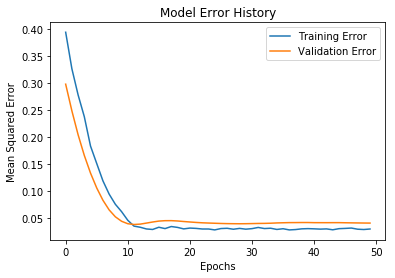

In [116]:
########################################################
# Accuracy evaluation of results
########################################################

# Invert the scaling
df_train = np.column_stack((trainPredict, train[:, 1:]))
trainPredict2 = scaler.inverse_transform(df_train)

df_validate = np.column_stack((validatePredict, validate[:, 1:]))
validatePredict2 = scaler.inverse_transform(df_validate)

# Plot the errors of the epochs and MSE
plt.plot(modelEstimate.history['loss'])
plt.plot(modelEstimate.history['val_loss'])
#  plt.plot(modelEstimate.history['val_acc'])
plt.title('Model Error History')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend(['Training Error', 'Validation Error'])
plt.show()

In [117]:
########################################################
# Output final results
########################################################

# Combine the final datasest - merge the training and validation datasets and rename columns
combined_dataframe = pd.concat([pd.DataFrame(trainPredict2), pd.DataFrame(validatePredict2)])
combined_dataframe.index = range(len(combined_dataframe))

# Add columns names to the data frame with the forecasts
names_list = list(inputDataFrame)[1:]
names_list[0] = 'lstm_forecast_brent_price'

combined_dataframe.columns = names_list

actual_value_target = pd.DataFrame(dataframe[:, 0])
actual_value_target.columns = ['actual_brent_price']

# Output the forecasts. Create the dataframe and write it to a CSV file
final_forecast_file = pd.concat([actual_value_target, combined_dataframe], axis = 1)
final_forecast_file.to_csv(dataLocation + inputFile + "_withForecasts" + ".csv", sep = ',')

In [85]:
%whos

Variable              Type            Data/Info
-----------------------------------------------
Dense                 type            <class 'keras.layers.core.Dense'>
Dropout               type            <class 'keras.layers.core.Dropout'>
K                     module          <module 'keras.backend' f<...>ras/backend/__init__.py'>
LSTM                  type            <class 'keras.layers.recurrent.LSTM'>
MinMaxScaler          type            <class 'sklearn.preprocessing.data.MinMaxScaler'>
Sequential            type            <class 'keras.models.Sequential'>
actual_value_target   DataFrame           actual_brent_price\n0<...>n\n[207 rows x 1 columns]
brentPriceArr         ndarray         207x28: 5796 elems, type `object`, 46368 bytes
brentPriceDf          DataFrame                 date    target <...>\n[207 rows x 28 columns]
combined_dataframe    DataFrame            lstm_forecast_brent_<...>\n[207 rows x 27 columns]
cwd                   str             /home/valentint/EAA_Ana